# **Titanic: Predicting Survival with Advanced Feature Engineering & a Neural Network**

Welcome to this analysis of the Titanic dataset! The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.

### **Goal**
The primary goal of this notebook is to build a predictive model that can accurately determine whether a passenger would have survived the disaster. We will use passenger data (e.g., age, sex, class, fare) to make this prediction.

### **Workflow**
This notebook will follow a structured machine learning workflow:

1.  **Data Loading & Initial Inspection:** We'll start by loading the training and testing datasets and performing a preliminary inspection to understand their structure, data types, and identify missing values.
2.  **Exploratory Data Analysis (EDA):** We will dive deep into the data, using visualizations to uncover patterns, relationships, and insights about how different features correlate with survival.
3.  **Feature Engineering & Preprocessing:** This is the core of our approach. We will:
    * Impute missing values, most notably using an ensemble of machine learning models to predict `Age`.
    * Engineer a rich set of new features from existing ones to capture complex relationships (e.g., family size, social status, ticket characteristics).
    * Encode categorical variables and scale numerical features to prepare the data for our model.
4.  **Modeling:** We will build, train, and evaluate a Neural Network using TensorFlow and Keras. The model is designed to learn from the complex features we've created.
5.  **Prediction & Submission:** Finally, we'll use our trained model to predict survival for the passengers in the test set and generate a submission file for the Kaggle competition.

Let's begin!

## **1. Importing Libraries**
First, we'll import all the necessary Python libraries for data manipulation, visualization, and machine learning.

In [1]:
# --- Data Manipulation ---
import pandas as pd
import numpy as np
import re
import random
import os

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning & Preprocessing ---
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# --- Utilities ---
import warnings
warnings.filterwarnings('ignore') # Ignore warning messages for cleaner output

In [2]:
# Set seeds
SEED = 28
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


## **2. Data Loading**
Here, we load the training and test datasets from the provided CSV files. We'll create copies to ensure the original dataframes remain untouched.

In [3]:
# Load the datasets from CSV files
df_train_raw = pd.read_csv('./data/train.csv')
df_test_raw = pd.read_csv('./data/test.csv')

# Create copies for manipulation
dftrain = df_train_raw.copy()
dftest = df_test_raw.copy()

### **2.1. Initial Data Inspection**
Let's take a first look at the training data to understand its columns and the type of data they contain.

In [111]:
# Display the first 5 rows of the training dataframe
dftrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


And now a look at the test data. Note that it lacks the `Survived` column, as this is what we need to predict.

In [112]:
# Display the first 5 rows of the test dataframe
dftest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


The `.info()` method provides a concise summary of the dataframe, including the data type of each column and the number of non-null values.

In [113]:
# Get a summary of the training data, including data types and non-null counts
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We do the same for the test set to check for consistency and identify missing data.

In [114]:
# Get a summary of the test data
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Let's quantify the missing values in the training set. `Age`, `Cabin`, and `Embarked` have missing entries that we'll need to handle.

In [115]:
# Count the number of null (missing) values in each column of the training set
dftrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Similarly, we check for missing values in the test set. `Age`, `Fare`, and `Cabin` are the columns with missing data here.

In [116]:
# Count the number of null (missing) values in each column of the test set
dftest.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The `.describe()` method gives us statistical details like mean, standard deviation, and quartiles for the numerical columns.

In [117]:
# Generate descriptive statistics for the numerical columns in the training set
dftrain.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## **3. Exploratory Data Analysis (EDA)**
Now, let's visualize the data to uncover insights and relationships between features and the survival outcome.

### **3.1. Distribution of Survival**
First, we'll see the distribution of our target variable, `Survived`. (0 = Did not survive, 1 = Survived).

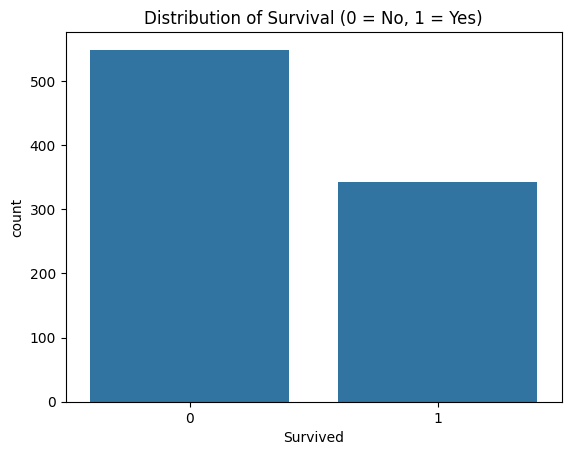

In [118]:
# Plot the distribution of the 'Survived' column
sns.countplot(x='Survived', data=dftrain)
plt.title('Distribution of Survival (0 = No, 1 = Yes)')
plt.show()

### **3.2. Age Distribution**
Next, let's look at the age distribution of the passengers. This will be helpful before we decide on a strategy for imputing missing ages.

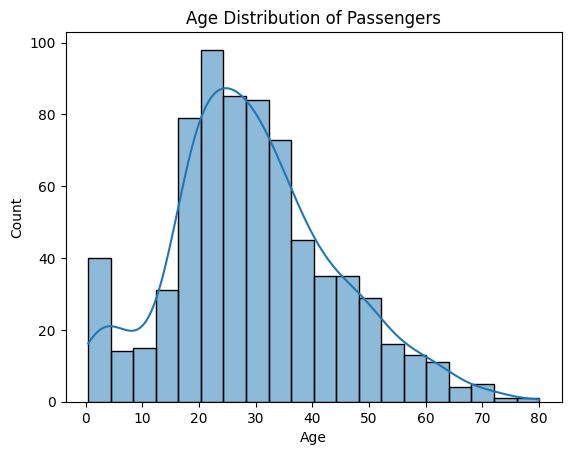

In [119]:
# Plot the distribution of passenger ages
sns.histplot(dftrain.Age.dropna(), kde=True)
plt.title('Age Distribution of Passengers')
plt.show()

### **3.3. Counts of Categorical Features**
Here, we'll visualize the counts for key categorical features to understand their composition.

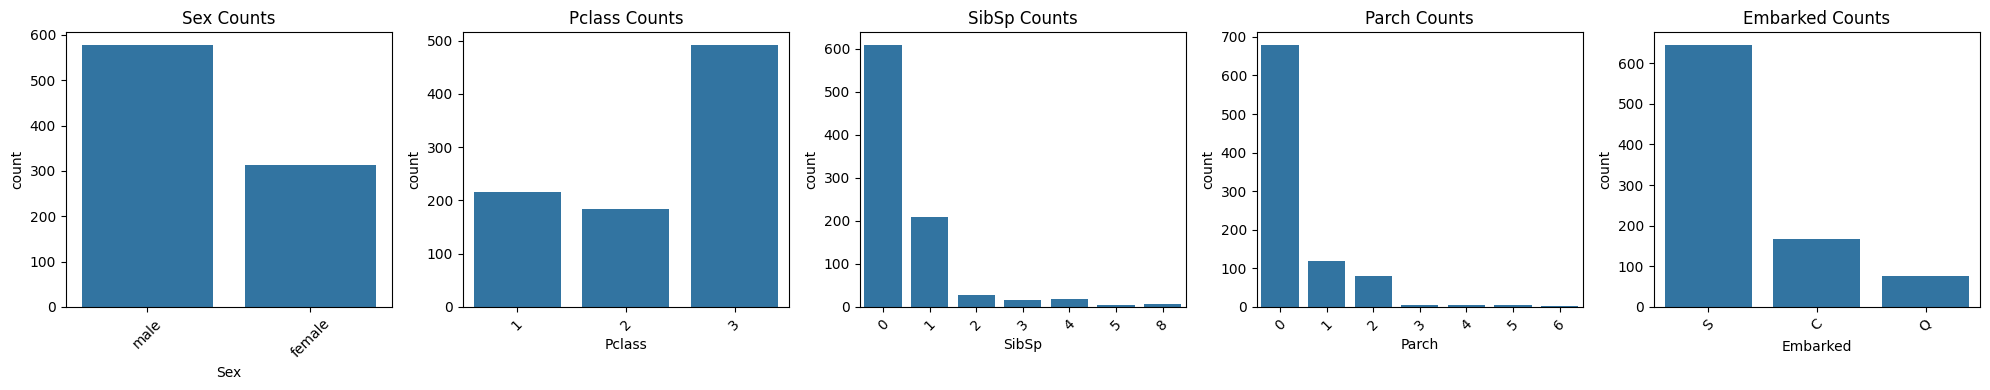

In [120]:
# Define the categorical columns to plot
countplot_cols = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs = axs.flatten() # Flatten the axes array for easy iteration

# Loop through the columns and create a count plot for each
for i, col in enumerate(countplot_cols):
    sns.countplot(x=col, data=dftrain, ax=axs[i])
    axs[i].set_title(f'{col} Counts')
    axs[i].tick_params(axis='x', rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### **3.4. Survival Analysis by Feature**

Now for the most important part of EDA: how do different features relate to survival?

We will create new features (`title`, `FareGroup`, `has_cabin`) and then plot both the survival count and survival rate for each category within our key features. This will give us a clear idea of which groups had a higher chance of survival.

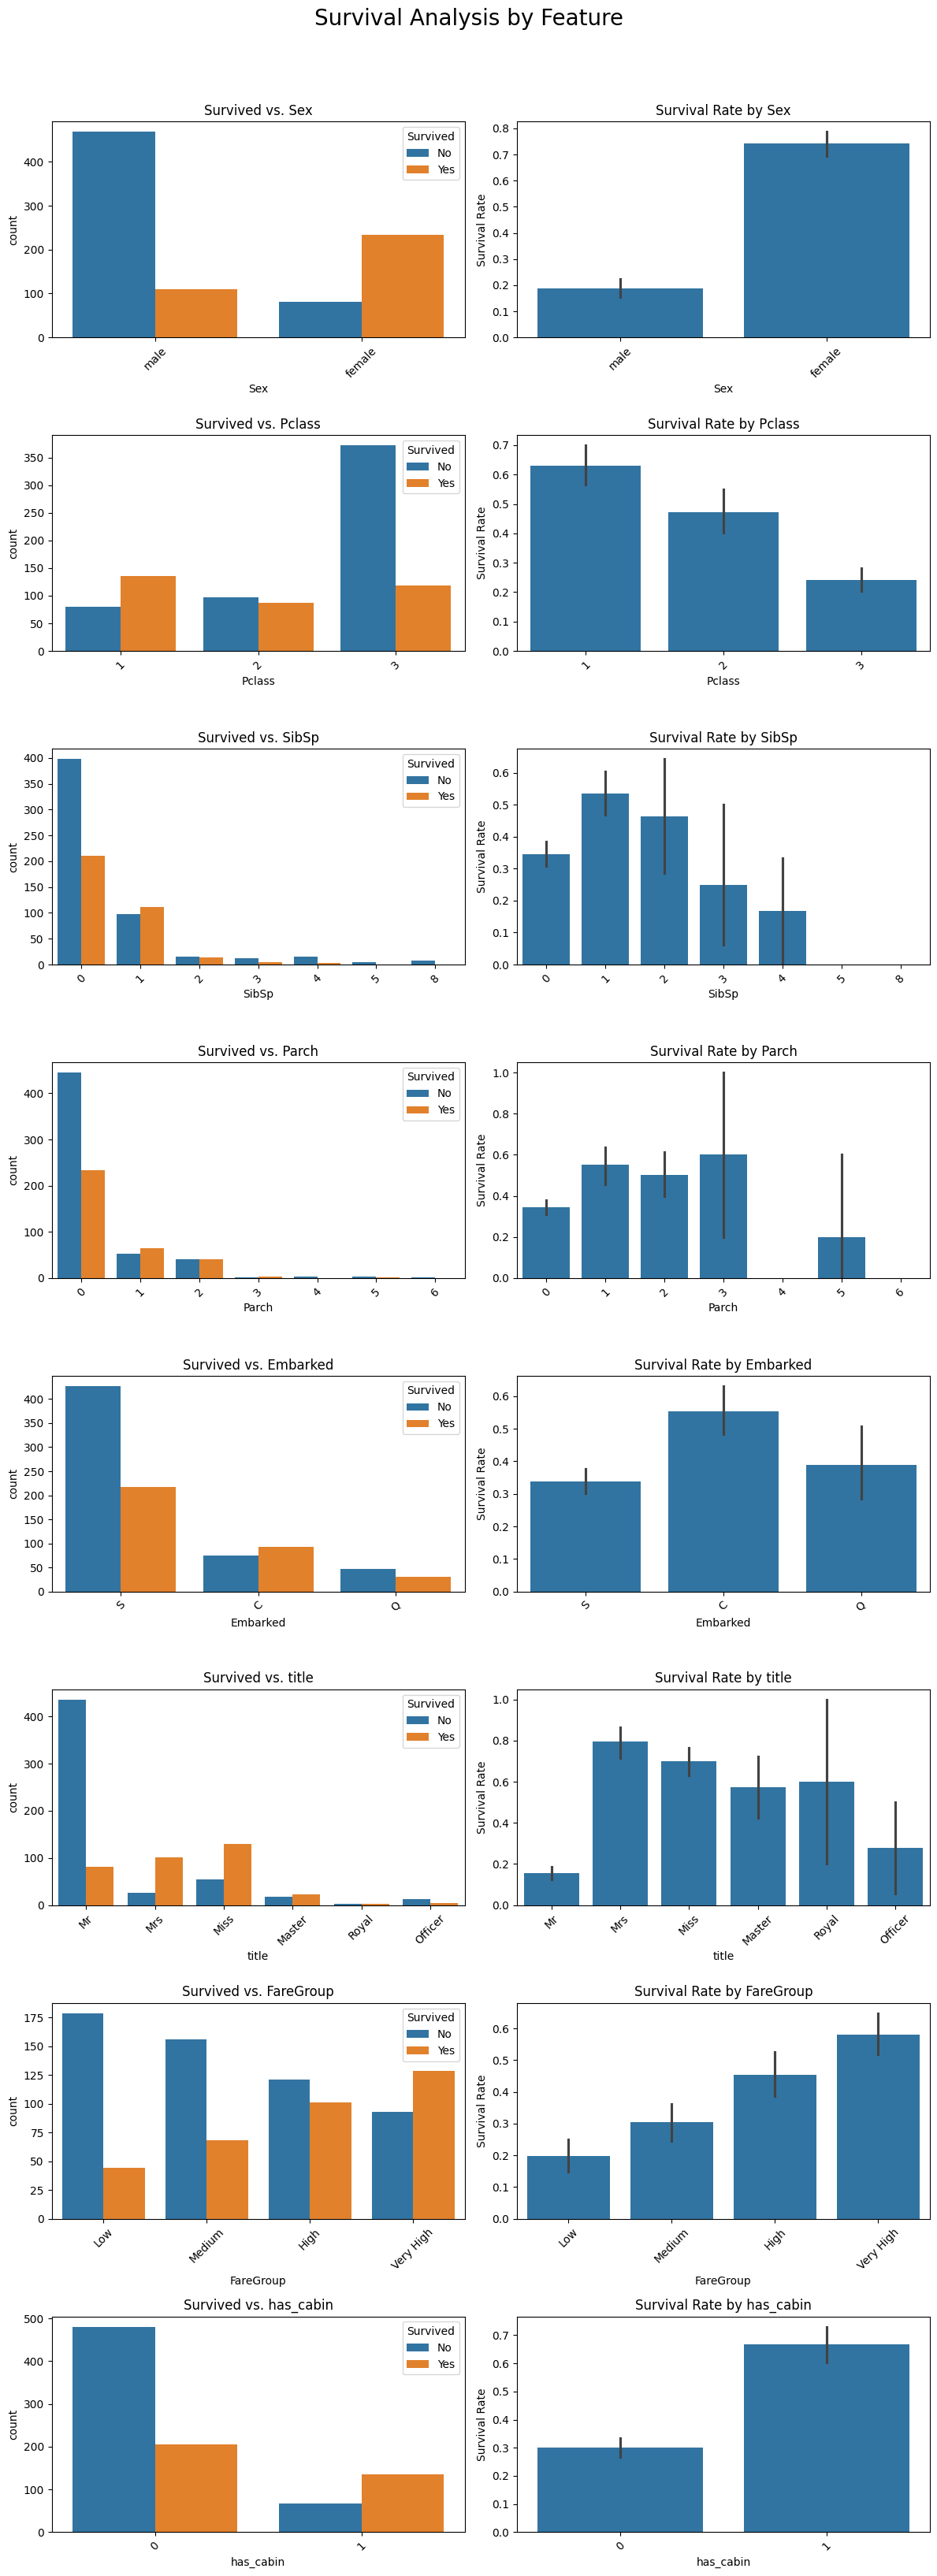

In [121]:
# --- Feature Engineering for EDA ---

# Extract titles (e.g., Mr, Mrs, Miss) from the 'Name' column
dftrain['title'] = dftrain['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Consolidate titles into broader categories
title_mapping = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Officer', 'Rev': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
    'Mlle': 'Miss', 'Countess': 'Royal', 'Ms': 'Mrs', 'Lady': 'Royal',
    'Jonkheer': 'Royal', 'Don': 'Royal', 'Dona': 'Royal', 'Mme': 'Mrs',
    'Capt': 'Officer', 'Sir': 'Royal'
}
dftrain['title'] = dftrain['title'].map(title_mapping).fillna('Rare')

# Create fare groups by splitting 'Fare' into 4 quantiles (quartiles)
dftrain['FareGroup'] = pd.qcut(dftrain['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Create a binary feature indicating if a passenger had a cabin number recorded
dftrain['has_cabin'] = dftrain['Cabin'].notnull().astype(int)

# --- Visualization ---

# List of features to analyze against survival
survival_rate_cols = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'title', 'FareGroup', 'has_cabin']

# Setup for subplots
n_cols = 2
n_rows = len(survival_rate_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
fig.suptitle('Survival Analysis by Feature', fontsize=20, y=1.02)

# Generate plots for each feature
for i, col in enumerate(survival_rate_cols):
    # Plot 1: Survival Count (e.g., how many men survived vs. didn't)
    sns.countplot(x=col, hue='Survived', data=dftrain, ax=axs[i, 0])
    axs[i, 0].set_title(f'Survived vs. {col}')
    axs[i, 0].tick_params(axis='x', rotation=45)
    axs[i, 0].legend(title='Survived', labels=['No', 'Yes'])

    # Plot 2: Survival Rate (e.g., what percentage of men survived)
    sns.barplot(x=col, y='Survived', data=dftrain, ax=axs[i, 1])
    axs[i, 1].set_title(f'Survival Rate by {col}')
    axs[i, 1].set_ylabel('Survival Rate')
    axs[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to make space for suptitle
plt.show()

### **3.5. Survival by Fare**
A box plot is a great way to see the distribution of `Fare` for those who survived versus those who didn't. It appears that passengers who paid a higher fare had a better chance of survival.

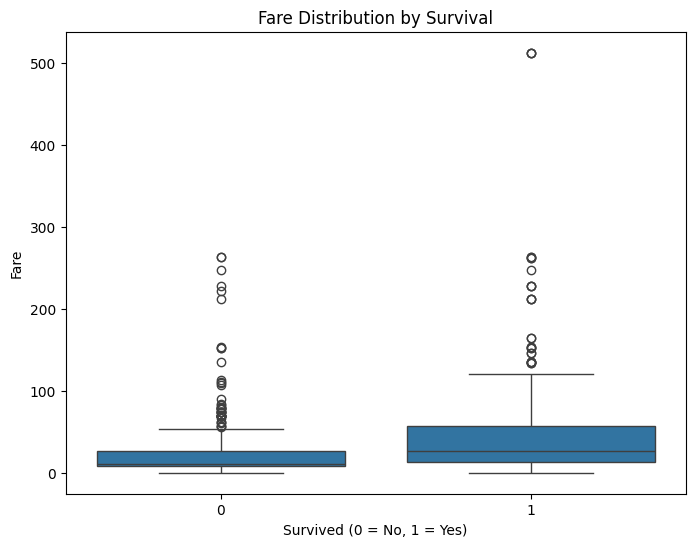

In [122]:
# Create a box plot to show the distribution of 'Fare' for each survival outcome
plt.figure(figsize=(8, 6))
sns.boxplot(x='Survived', y='Fare', data=dftrain)
plt.title('Fare Distribution by Survival')
plt.ylabel("Fare")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.show()

### **3.6. Survival by Age Group**
To better analyze the relationship between age and survival, we can group ages into bins and calculate the survival rate for each group.

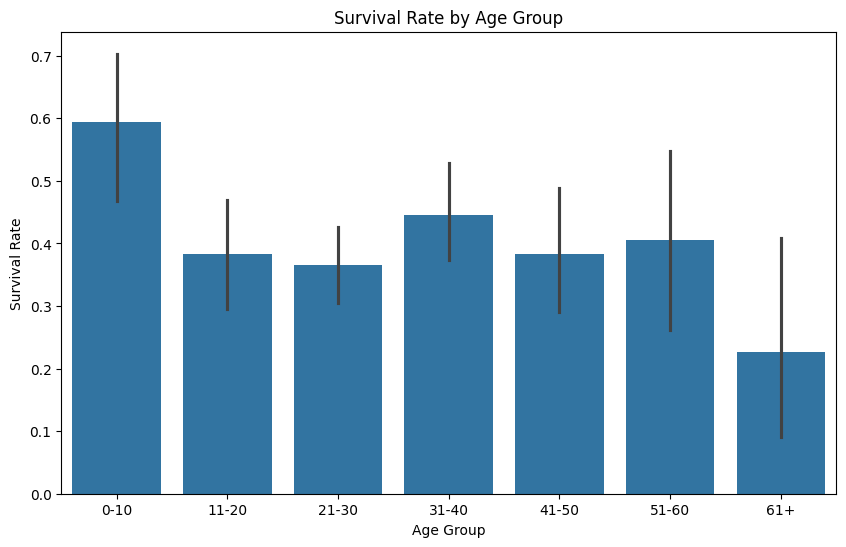

In [123]:
# Create age bins to group passengers
dftrain['AgeGroup'] = pd.cut(dftrain['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 80],
                             labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61+'])

# Plot the survival rate for each age group
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Survived', data=dftrain)
plt.title('Survival Rate by Age Group')
plt.ylabel('Survival Rate')
plt.xlabel('Age Group')
plt.show()

### **3.7. Age Distribution by Survival (KDE)**
A Kernel Density Estimate (KDE) plot provides a smoothed view of the age distribution for survivors and non-survivors. We can see that young children had a higher survival rate, while young adults (20-40) had a lower rate.

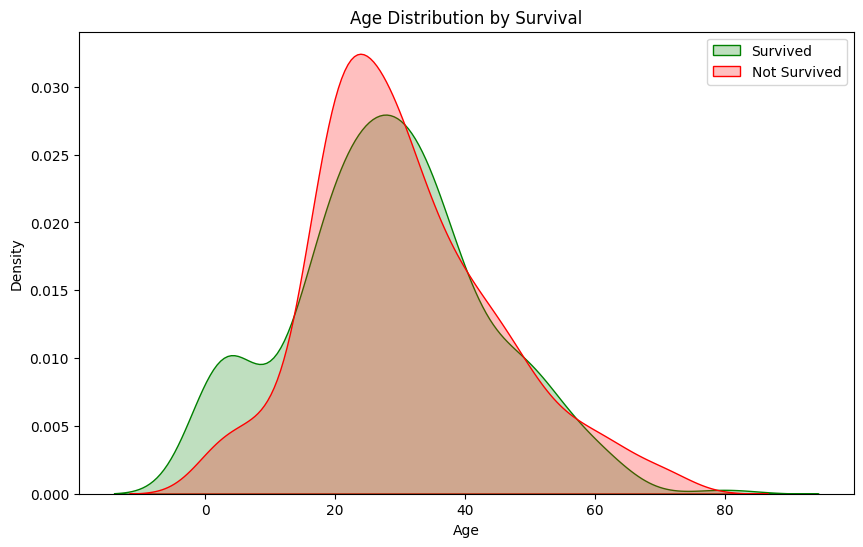

In [124]:
plt.figure(figsize=(10, 6))

# Plot KDE for survived passengers
sns.kdeplot(dftrain[dftrain['Survived'] == 1]['Age'], label='Survived', shade=True, color='green')
# Plot KDE for non-survived passengers
sns.kdeplot(dftrain[dftrain['Survived'] == 0]['Age'], label='Not Survived', shade=True, color='red')

plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.legend()
plt.show()

## **4. Feature Engineering & Preprocessing**

This is the most critical stage. We will create three main functions:
1. `feature_engineering_for_age`: A sophisticated function based on some features that contains some features created based on correlation
2.  `impute_age`: A sophisticated function to fill missing `Age` values using an ensemble of LightGBM and Random Forest models.
3.  `feature_engineering`: A comprehensive function to create all our features, handle missing values, and encode categorical data.

This structured approach ensures that both the training and test data are processed identically.  
First lets see correlation for `Age`.

### **4.1. Feature Engineering for age Function**  
First lets see correlation related `Age`.

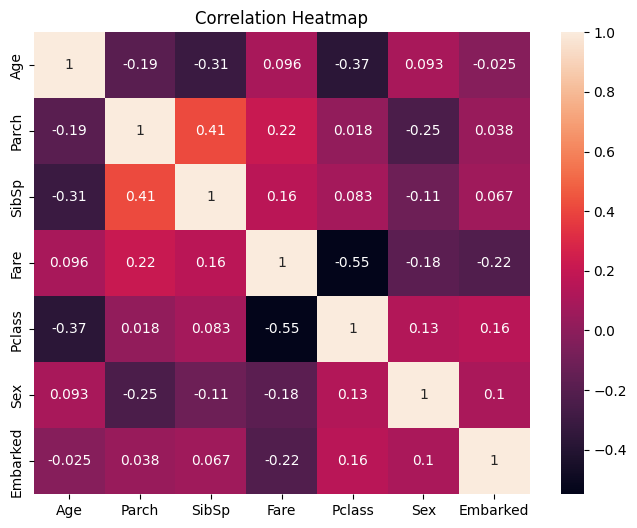

In [125]:
df_encoded = df_train_raw.copy()
cat_feat = ['Sex', 'Embarked']
for col in cat_feat:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
features_for_corr = ['Age', 'Parch', 'SibSp', 'Fare', 
                     'Pclass', 'Sex', 'Embarked']
corr = df_encoded[features_for_corr].corr()
plt.figure(figsize= (8, 6))
sns.heatmap(corr, annot= True)
plt.title('Correlation Heatmap')
plt.show()

As you see these features doesn't related too much too Age.Let's see what we can do to created some better features.

In [4]:
def feature_engineering_for_age(df):
    """
    Performs feature engineering to create new variables and handle initial missing values.
    This function prepares features useful for general modeling tasks and especially for 
    predicting missing 'Age' values.

    Args:
        df (pd.DataFrame): The input dataframe (train or test).

    Returns:
        Tuple[pd.DataFrame, List[str]]: The dataframe with engineered features,
        and a list of feature names useful for imputing 'Age'.
    """

    # ========== Handling Missing Values ==========
    
    # Impute missing 'Fare' with the median fare of each passenger class
    if df['Fare'].isnull().any():
        median_fare = df.groupby('Pclass')['Fare'].transform('median')
        df['Fare'].fillna(median_fare, inplace=True)
    
    # Fill missing 'Embarked' with the most frequent port
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    # ========== Feature Extraction ==========

    # Extract title from passenger names (e.g., Mr, Miss, Dr)
    df['title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

    # Binary indicator for presence of cabin information
    df['has_cabin'] = df['Cabin'].notnull().astype(int)

    # Calculate family size including the passenger
    df['family_size'] = df['SibSp'] + df['Parch'] + 1

    # Extract deck letter from Cabin (can be multiple for shared cabins)
    df['decks'] = df['Cabin'].str.findall(r'([A-Za-z])')

    # Count how many people share the same ticket (ticket group size)
    df['ticket_group_size'] = df.groupby('Ticket')['Ticket'].transform('count')

    # ========== Title Grouping and Encoding ==========

    # Map raw titles to broader, standardized categories
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Officer', 'Rev': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
        'Mlle': 'Miss', 'Countess': 'Royal', 'Ms': 'Mrs', 'Lady': 'Royal',
        'Jonkheer': 'Royal', 'Don': 'Royal', 'Dona': 'Royal', 'Mme': 'Mrs',
        'Capt': 'Officer', 'Sir': 'Royal'
    }
    df['title'] = df['title'].map(title_mapping).fillna('Rare')

    # Fill missing decks with placeholder
    df['decks'] = df['decks'].fillna('Unknown')

    # Encode title as numerical feature
    le = LabelEncoder()
    df['title_encoded'] = le.fit_transform(df['title'])

    # ========== Derived and Interaction Features ==========

    # Indicator: whether the passenger is a child (Master)
    df['is_child'] = (df['title'] == 'Master').astype(int)

    # Indicator: whether the passenger is likely a parent (Mr or Mrs with family)
    df['is_parent'] = ((df['title'].isin(['Mr', 'Mrs'])) & (df['family_size'] > 1)).astype(int)

    # Cabin wealth feature: fare adjusted by cabin presence
    df['cabin_wealth'] = df['has_cabin'] * np.log1p(df['Fare'])

    # Difference between total family size and number of parents/children
    df['family_size_parch'] = df['family_size'] - df['Parch']

    # Interaction of ticket group size with passenger class
    df['ticket_size_class'] = df['ticket_group_size'] * df['Pclass']

    # Interaction categorical features for modeling
    df['title_decks'] = df['title'].astype(str) + '_' + df['decks'].astype(str)
    df['title_sex'] = df['title'].astype(str) + '_' + df['Sex'].astype(str)

    # Numerical interaction features
    df['title_family_size'] = df['title_encoded'] * df['family_size']
    df['title_fare'] = df['title_encoded'] * df['Fare']

    # ========== Features Useful for Age Imputation ==========
    age_features = [
        'title_encoded', 'title_decks', 'title_sex', 'is_parent', 'cabin_wealth',
        'title_fare', 'title_family_size', 'ticket_group_size', 'is_child',
        'family_size_parch', 'ticket_size_class'
    ]

    # ========== Metadata and Logging ==========
    df.attrs['name'] = 'Raw DataFrame'
    print(f"The {df.attrs['name']} has filled these new features for missing age imputation.")
    print(f"New features used for imputing age:\n{', '.join(age_features)}")

    return df, age_features


Now use our function to create a new DataFrame.  
**Note** : We need to keep these new `DataFrames` to use it later. for more robusted way 

In [5]:
df_train_raw2, age_features = feature_engineering_for_age(df_train_raw)

The Raw DataFrame has filled these new features for missing age imputation.
New features used for imputing age:
title_encoded, title_decks, title_sex, is_parent, cabin_wealth, title_fare, title_family_size, ticket_group_size, is_child, family_size_parch, ticket_size_class


In [6]:
df_test_raw2, _ = feature_engineering_for_age(df_test_raw)

The Raw DataFrame has filled these new features for missing age imputation.
New features used for imputing age:
title_encoded, title_decks, title_sex, is_parent, cabin_wealth, title_fare, title_family_size, ticket_group_size, is_child, family_size_parch, ticket_size_class


Let's see new columns first in train set.

In [129]:
df_train_raw2.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'title', 'has_cabin',
       'family_size', 'decks', 'ticket_group_size', 'title_encoded',
       'is_child', 'is_parent', 'cabin_wealth', 'family_size_parch',
       'ticket_size_class', 'title_decks', 'title_sex', 'title_family_size',
       'title_fare'],
      dtype='object')

Let's see now what `correlation` for *age* receive with this new features that we created.

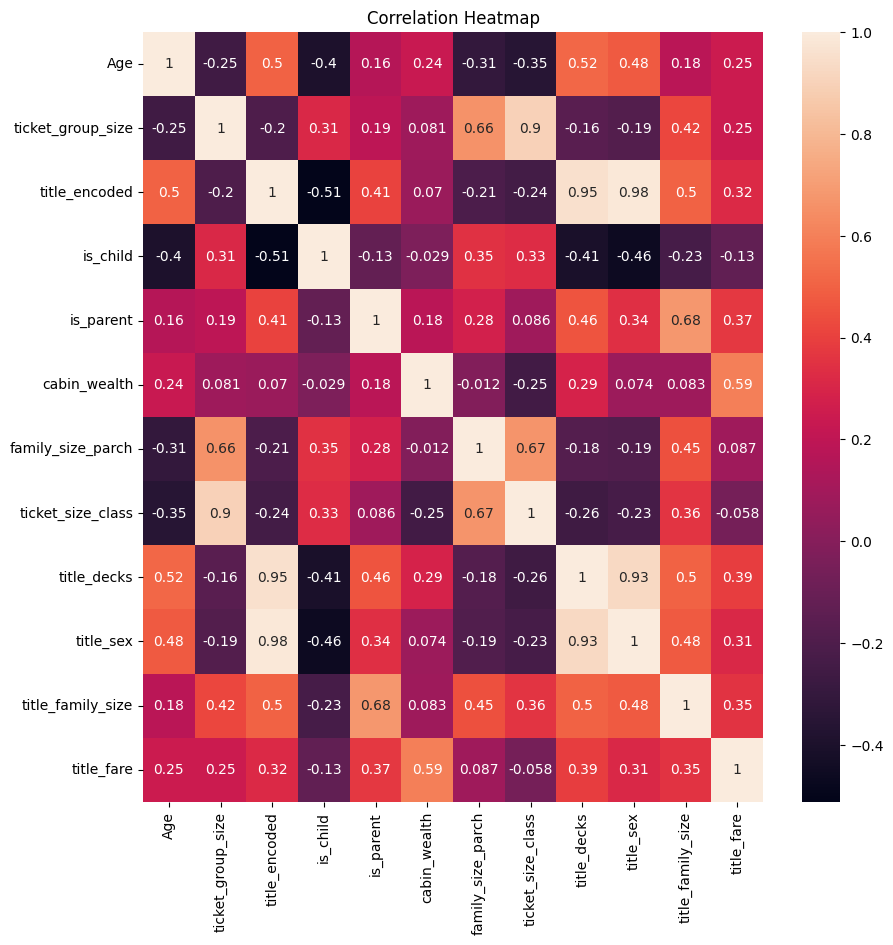

In [130]:
df_enc = df_train_raw2.copy()
df_enc.drop(['Survived', 'Ticket', 'Name', 'PassengerId', 'Cabin'], axis= 1, inplace= True)
cat_feat = ['title_decks', 'title_sex', 'Sex']
for col in cat_feat:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))

corr_feat = ['Age', 'ticket_group_size', 'title_encoded', 'is_child',
       'is_parent', 'cabin_wealth', 'family_size_parch', 'ticket_size_class',
       'title_decks', 'title_sex', 'title_family_size', 'title_fare', 
]
corr = df_enc[corr_feat].corr()
plt.figure(figsize= (10, 10))
sns.heatmap(corr, annot= True)
plt.title('Correlation Heatmap')
plt.show()

as you see now we have stronger `features` to impute age based on these.  
Let's do it!

### 4.2. Age Imputation with LightGBM and Random Forest

This function fills missing `Age` values using a weighted average of predictions from:

- **LightGBM** (default weight = 0.6)
- **Random Forest** (default weight = 0.4)

It trains both models on rows with known ages using `age_features`, then imputes the missing values. Predictions are clipped between 0 and 80 for realism.

**Returns:** Updated DataFrame with imputed `Age`.


In [7]:
def impute_age(df, age_features= age_features, lgb_weight=0.6, rf_weight=0.4):
    """
    Imputes missing 'Age' values using a weighted ensemble of LightGBM and
    Random Forest regressors.

    This function:
    - Splits the data into rows with known and missing ages.
    - Trains LightGBM and Random Forest models on known age data.
    - Predicts the missing ages using both models.
    - Creates a weighted ensemble of the predictions.
    - Fills in the missing 'Age' values using the ensemble output.

    Args:
        df (pd.DataFrame): The input dataframe (train or test).
        age_features (List[str]): The feature list used to predict age.
        lgb_weight (float): Weight of LightGBM model in the ensemble.
        rf_weight (float): Weight of Random Forest model in the ensemble.

    Returns:
        pd.DataFrame: The dataframe with missing 'Age' values imputed.
    """
    # Make a copy to avoid modifying the original dataframe
    df_temp = df.copy()

    # --- Step 2: Split data into known and unknown age groups ---
    age_known_df = df_temp[df_temp['Age'].notnull()]
    age_missing_df = df_temp[df_temp['Age'].isnull()]

    # If no ages are missing, return the original dataframe
    if age_missing_df.empty:
        return df

    # Prepare training data (X) and target (y)
    X_train_age = age_known_df[age_features]
    y_train_age = age_known_df['Age']
    X_pred_age = age_missing_df[age_features]
    
    # Prepare data for both models
    X_train_lgb = X_train_age.copy()
    X_pred_lgb = X_pred_age.copy()
    X_train_rf = X_train_age.copy()
    X_pred_rf = X_pred_age.copy()

    # --- Step 3: Train and predict with LightGBM ---
    categorical_cols = ['title_sex', 'title_decks', 'title_encoded']
    for col in categorical_cols:
        X_train_lgb[col] = X_train_lgb[col].astype('category')
        X_pred_lgb[col] = X_pred_lgb[col].astype('category')
    lgb_model = LGBMRegressor(
        objective='regression',
        n_estimators=80,
        learning_rate=0.08,
        num_leaves=15,
        min_child_samples=15,
        min_split_gain=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=SEED,
        verbose=-1
    )
    
    lgb_model.fit(X_train_lgb, y_train_age, categorical_feature=categorical_cols)
    lgb_pred = lgb_model.predict(X_pred_lgb)

    # --- Step 4: Train and predict with Random Forest ---
    # Encode categorical features for Random Forest
    for col in ['title_decks', 'title_sex']:
        le = LabelEncoder()
        X_train_rf[col] = le.fit_transform(X_train_rf[col])
        X_pred_rf[col] = le.fit_transform(X_pred_rf[col])
    rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=12,
        min_samples_split=8,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=SEED,
        n_jobs=-1
    )
    rf_model.fit(X_train_rf, y_train_age)
    rf_pred = rf_model.predict(X_pred_rf)

    # --- Step 5: Create weighted ensemble prediction ---
    # Combine predictions, giving slightly more weight to LGBM
    ensemble_pred = (lgb_weight * lgb_pred) + (rf_weight * rf_pred)
    ensemble_pred = np.clip(np.round(ensemble_pred), 0, 80) # Clip predictions to a realistic age range

    
    # --- Step 6: Fill in the missing ages in the original dataframe ---
    missing_age_indices = df[df['Age'].isnull()].index

    if len(missing_age_indices) == len(ensemble_pred):
        df.loc[missing_age_indices, 'Age'] = ensemble_pred
        print(f"Filled {len(ensemble_pred)} missing 'Age' values.")
        print(f"LightGBM weight: {lgb_weight}, Random Forest weight: {rf_weight}")
    else:
        print("⚠️ Warning: Length mismatch in age imputation. Skipping filling step.")
        print(f"Expected {len(missing_age_indices)} values, but got {len(ensemble_pred)} predictions.")

    return df

#### Clean Temporary Engineered Features

This function removes temporary features (e.g., used for age imputation) from the DataFrame:

- `title_encoded`, `decks`, `title_family_size`, `title_fare`, `title_decks`, `title_sex`

It returns a cleaned DataFrame with those columns dropped.


In [8]:
def df_cleaning(df):
    """
    Removes temporary or intermediate features from the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to clean.

    Returns:
        pd.DataFrame: The cleaned DataFrame without the specified features.
    """
    # List of engineered features used earlier (e.g., for age imputation) that are no longer needed
    cleaned_features = ['title_encoded', 'decks', 'title_family_size', 
                        'title_fare', 'title_decks', 'title_sex']
    
    # Drop these columns from the DataFrame
    df.drop(cleaned_features, axis=1, inplace=True)

    # Log the cleanup
    print(f"{', '.join(cleaned_features)} has cleaned from DataFrame")
    
    return df


It's time to Imputation for $Age$ , we use last dataframe `df_train_raw2` and `age_features` for train dataset and `df_test_raw2` for test dataset.  
Then clean redundant features.

In [9]:
df_train_age_filled = impute_age(df_train_raw2, age_features, lgb_weight=0.6, rf_weight= 0.4)
df_test_age_filled = impute_age(df_test_raw2, age_features, lgb_weight=0.6, rf_weight= 0.4)

Filled 177 missing 'Age' values.
LightGBM weight: 0.6, Random Forest weight: 0.4
Filled 86 missing 'Age' values.
LightGBM weight: 0.6, Random Forest weight: 0.4


In [10]:
df_train_intermediate = df_cleaning(df_train_age_filled)

title_encoded, decks, title_family_size, title_fare, title_decks, title_sex has cleaned from DataFrame


In [11]:
df_test_intermediate = df_cleaning(df_test_age_filled)

title_encoded, decks, title_family_size, title_fare, title_decks, title_sex has cleaned from DataFrame


**Note** : As say before, keep the intermediate DataFrames for better inference and avoiding from creating some `features` again.

### **4.3. Main Feature Engineering Function**
This function is the heart of our data preparation pipeline. It takes an `intermediate` dataframe that created after age imputation and transforms it into a feature-rich dataset ready for a neural network.

### Fitting All Encoders on Train and Test Data

The function below fits all LabelEncoders required for feature engineering on the union of both train and test datasets.  
This ensures every possible class (including 'Unknown' or 'None') is recognized and prevents unseen-label errors when transforming either dataset.

In [12]:
def fit_all_encoders(df_train_raw, df_test_raw):
    """
    Fits label encoders on combined train and test sets for various categorical features
    to ensure consistent encoding across both datasets.

    Args:
        df_train_raw (pd.DataFrame): Raw training DataFrame.
        df_test_raw (pd.DataFrame): Raw test DataFrame.

    Returns:
        dict: A dictionary containing fitted LabelEncoders for:
            - title_grouped
            - Embarked
            - primary_deck
            - family_type
            - ticket_prefix
    """

    # --- Title Grouped ---
    # Extract and normalize titles from names, then map them to grouped categories
    train_titles = df_train_raw['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    test_titles = df_test_raw['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master', 'Dr': 'Officer',
        'Rev': 'Officer', 'Col': 'Officer', 'Major': 'Officer', 'Mlle': 'Miss',
        'Countess': 'Royal', 'Ms': 'Mrs', 'Lady': 'Royal', 'Jonkheer': 'Royal',
        'Don': 'Royal', 'Dona': 'Royal', 'Mme': 'Mrs', 'Capt': 'Officer', 'Sir': 'Royal'
    }
    
    all_titles = pd.concat([train_titles, test_titles], ignore_index=True)
    all_titles_grouped = all_titles.map(title_mapping).fillna('Rare').unique()
    
    le_title_grouped = LabelEncoder()
    le_title_grouped.fit(all_titles_grouped)

    # --- Embarked ---
    # Combine both datasets and fill missing values using the mode of training set
    all_embarked = pd.concat(
        [df_train_raw['Embarked'], df_test_raw['Embarked']], 
        ignore_index=True
    ).fillna(df_train_raw['Embarked'].mode()[0]).unique()
    
    le_embarked = LabelEncoder()
    le_embarked.fit(all_embarked)

    # --- Primary Deck ---
    # Extract first letter from Cabin as deck information, fill missing with 'Unknown'
    train_decks = df_train_raw['Cabin'].str.extract(r'^([A-Za-z])', expand=False).fillna('Unknown')
    test_decks = df_test_raw['Cabin'].str.extract(r'^([A-Za-z])', expand=False).fillna('Unknown')
    
    all_decks = pd.concat([train_decks, test_decks], ignore_index=True).unique()
    
    le_deck = LabelEncoder()
    le_deck.fit(all_decks)

    # --- Family Type ---
    # Encode predefined family categories
    all_family_types = ['Single', 'Couple', 'Small_Family', 'Large_Family']
    
    le_family_type = LabelEncoder()
    le_family_type.fit(all_family_types)

    # --- Ticket Prefix ---
    # Extract alphabetic prefix from Ticket field, fill missing with 'None'
    train_prefix = df_train_raw['Ticket'].str.extract('([A-Za-z]+)', expand=False).fillna('None')
    test_prefix = df_test_raw['Ticket'].str.extract('([A-Za-z]+)', expand=False).fillna('None')
    
    all_prefixes = pd.concat([train_prefix, test_prefix], ignore_index=True).unique()
    
    le_ticket_prefix = LabelEncoder()
    le_ticket_prefix.fit(all_prefixes)

    return {
        'title_grouped': le_title_grouped,
        'Embarked': le_embarked,
        'primary_deck': le_deck,
        'family_type': le_family_type,
        'ticket_prefix': le_ticket_prefix
    }


### Final Feature Engineering for Neural Network Models

This function builds on top of the earlier `feature_engineering_for_age()`.

✅ Assumptions:
- Some features like `title`, `family_size`, `has_cabin`, and `cabin_wealth` already exist.
- Temporary features created earlier (e.g. `title_decks`, `title_sex`) have already been cleaned.

### What it adds:
- Encoded categorical features: `title_encoded`, `deck_encoded`, `embarked_encoded`, etc.
- Interaction features tailored for neural networks.
- New numerical features like `fare_per_person_log`, `social_status`, and more.
- Logical groups for wealth, family, survival relevance, and social status.

Returns the final, enhanced DataFrame for deep learning models.


In [13]:
def feature_engineering(df, encoders):
    """
    Enhanced feature engineering specifically optimized for neural networks.
    Assumes some features were already created in feature_engineering_for_age and later cleaned.
    """
    df = df.copy()
    
    # Deck and cabin counts
    df['num_decks'] = df['Cabin'].apply(
        lambda x: 1 if pd.isnull(x) else len(re.findall(r'[A-Za-z]', x))
    )
    df['num_cabins'] = df['Cabin'].apply(lambda x: 1 if pd.isnull(x) else len(x.split()))
    
    # Alone indicator
    df['is_alone'] = (df['family_size'] == 1).astype(int)
    
    # Primary deck extraction and cleanup
    df['primary_deck'] = df['Cabin'].str.extract(r'^([A-Za-z])', expand=False)
    df['primary_deck'] = df['primary_deck'].fillna('Unknown')
    df['Cabin'] = df['Cabin'].fillna('Unknown')
    
    # Family type classification
    df['family_type'] = 'Single'
    df.loc[df['family_size'] == 2, 'family_type'] = 'Couple'
    df.loc[(df['family_size'] >= 3) & (df['family_size'] <= 4), 'family_type'] = 'Small_Family'
    df.loc[df['family_size'] >= 5, 'family_type'] = 'Large_Family'
    
    # Ticket prefix and binary indicator
    df['ticket_prefix'] = df['Ticket'].str.extract('([A-Za-z]+)', expand=False).fillna('None')
    df['has_ticket_prefix'] = (df['ticket_prefix'] != 'None').astype(int)

    # Sex encoding
    df['sex_encoded'] = df['Sex'].map({'male': 1, 'female': 0})

    # Label encode using pre-fitted encoders
    df['title_encoded'] = encoders['title_grouped'].transform(df['title'])
    df['embarked_encoded'] = encoders['Embarked'].transform(df['Embarked'])
    df['deck_encoded'] = encoders['primary_deck'].transform(df['primary_deck'])
    df['family_type_encoded'] = encoders['family_type'].transform(df['family_type'])
    df['ticket_prefix_encoded'] = encoders['ticket_prefix'].transform(df['ticket_prefix'])

    # Log-transform fares
    df['log_fare'] = np.log1p(df['Fare'])
    df['fare_per_person'] = df['Fare'] / df['family_size']
    df['fare_per_person_log'] = np.log1p(df['fare_per_person'])

    # Bin fare and age into quantiles and groups
    df['fare_quartile'] = pd.qcut(df['Fare'], 4, labels=False)
    df['age_group'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=False)

    # Interaction features for NN
    df['age_class'] = df['Age'] * df['Pclass']
    df['fare_class'] = df['log_fare'] * df['Pclass']
    df['sex_class'] = df['sex_encoded'] * df['Pclass']
    df['title_class'] = df['title_encoded'] * df['Pclass']
    df['deck_class'] = df['deck_encoded'] * df['Pclass']
    df['family_fare'] = df['family_size'] * df['log_fare']
    df['title_age'] = df['title_encoded'] * df['Age']
    df['cabin_class'] = df['has_cabin'] * df['Pclass']

    # Social status interaction
    df['title_family_interaction'] = df['title_encoded'] * df['family_size']
    df['wealth_indicator'] = df['cabin_wealth'] + df['log_fare'] + (df['Pclass'] * -1)

    # Survival-related features
    df['women_children_first'] = ((df['sex_encoded'] == 0) | (df['Age'] < 16)).astype(int)
    df['adult_male'] = ((df['sex_encoded'] == 1) & (df['Age'] >= 16)).astype(int)
    df['family_with_cabin'] = df['family_size'] * df['has_cabin']

    # Social status score based on multiple traits
    df['social_status'] = (
        (df['Pclass'] == 1).astype(int) * 3 +
        df['has_cabin'] * 2 +
        df['has_ticket_prefix'] * 1 +
        (df['title_encoded'] == encoders['title_grouped'].transform(['Royal'])[0]) * 4
    )

    print(f"All new features added Successfully!\nAll Features:\n{', '.join(df.columns)}\nNumber of features: {len(df.columns)}")
    
    return df


### **4.3. Applying Feature Engineering**
Now we apply the `feature_engineering` function to our raw training and test dataframes to create our final, processed datasets.

In [14]:
# 1. Fit all encoders on the union of train & test data
# IMPORTANT: USE INTERMEDIATE DFs
encoders = fit_all_encoders(df_train_raw, df_test_raw)

# Process the training data
df_train_processed = feature_engineering(df_train_intermediate, encoders= encoders)

# Process the test data
df_test_processed = feature_engineering(df_test_intermediate, encoders= encoders)

All new features added Successfully!
All Features:
PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, title, has_cabin, family_size, ticket_group_size, is_child, is_parent, cabin_wealth, family_size_parch, ticket_size_class, num_decks, num_cabins, is_alone, primary_deck, family_type, ticket_prefix, has_ticket_prefix, sex_encoded, title_encoded, embarked_encoded, deck_encoded, family_type_encoded, ticket_prefix_encoded, log_fare, fare_per_person, fare_per_person_log, fare_quartile, age_group, age_class, fare_class, sex_class, title_class, deck_class, family_fare, title_age, cabin_class, title_family_interaction, wealth_indicator, women_children_first, adult_male, family_with_cabin, social_status
Number of features: 53
All new features added Successfully!
All Features:
PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, title, has_cabin, family_size, ticket_group_size, is_child, is_parent, cabin_wealth, family_size_pa

In [16]:
df_train_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,deck_class,family_fare,title_age,cabin_class,title_family_interaction,wealth_indicator,women_children_first,adult_male,family_with_cabin,social_status
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,24,4.220426,44.0,0,4,-0.889787,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,2,8.561186,114.0,1,6,7.561186,1,0,2,6
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,24,2.188856,26.0,0,1,-0.811144,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,2,7.981668,105.0,1,6,6.981668,1,0,2,5
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,24,2.202765,70.0,0,2,-0.797235,0,1,0,0


In [140]:
df_test_processed.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,deck_class,family_fare,title_age,cabin_class,title_family_interaction,wealth_indicator,women_children_first,adult_male,family_with_cabin,social_status
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,...,24,2.178064,69.0,0,2,-0.821936,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,...,24,4.158883,141.0,0,6,-0.920558,1,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,...,16,2.369075,124.0,0,2,0.369075,0,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,...,24,2.268252,54.0,0,2,-0.731748,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,...,24,7.760471,66.0,0,9,-0.413176,1,0,0,0


## **5. Model Preparation**
We need to select the final set of features that will be fed into our neural network and then scale them.

### **5.1. Define Feature Set**
Here, we curate a list of all the engineered and encoded features we want to use for training.

In [141]:
def get_nn_features():
    """
    Returns a curated set of features for neural network training
    grouped by logical categories.
    """
    return [
        # Basic identity
        'sex_encoded', 'Pclass', 'Age',

        # Family-related
        'SibSp', 'Parch', 'family_size', 'is_alone', 'family_size_parch',
        'family_type_encoded', 'family_with_cabin',

        # Economic/wealth indicators
        'fare_per_person_log', 'fare_quartile', 'cabin_wealth', 'wealth_indicator',

        # Title & social roles
        'title_encoded', 'is_child', 'is_parent', 'title_class', 'social_status',

        # Cabin info
        'has_cabin', 'num_cabins', 'deck_encoded', 'num_decks', 'deck_class',

        # Ticket info
        'ticket_group_size', 'ticket_size_class', 'ticket_prefix_encoded', 'has_ticket_prefix',

        # Encoded location data
        'embarked_encoded',

        # Interaction / engineered features
        'age_group', 'age_class', 'fare_class', 'sex_class',
        'title_age', 'title_family_interaction', 'cabin_class',
        'family_fare', 'women_children_first', 'adult_male'
    ]

# Get the list of features
features = get_nn_features()

# Print the number of features to confirm
print(f"Number of features for NN: {len(features)}")
print(f"Features using in NN:\n{', '.join(features)}")

Number of features for NN: 39
Features using in NN:
sex_encoded, Pclass, Age, SibSp, Parch, family_size, is_alone, family_size_parch, family_type_encoded, family_with_cabin, fare_per_person_log, fare_quartile, cabin_wealth, wealth_indicator, title_encoded, is_child, is_parent, title_class, social_status, has_cabin, num_cabins, deck_encoded, num_decks, deck_class, ticket_group_size, ticket_size_class, ticket_prefix_encoded, has_ticket_prefix, embarked_encoded, age_group, age_class, fare_class, sex_class, title_age, title_family_interaction, cabin_class, family_fare, women_children_first, adult_male


### **5.2. Scaling the Features**
Neural networks perform best when numerical input features are scaled to a common range. We'll use `StandardScaler`, which standardizes features by removing the mean and scaling to unit variance.

#### Prepare Data for Neural Network Training

This function prepares the dataset for neural network input by:

- Selecting specified features.
- Extracting the target variable (`Survived`).
- Scaling features using `StandardScaler` for normalized input.

Returns:
- Scaled feature DataFrame (`X_train_scaled`)
- Target Series (`y_train`)
- The fitted scaler object for using on test data.


In [152]:
def prepare_for_nn(df, features= features):
    """
    Final preparation for neural network training
    """
    # Prepare training data
    X_train = df[features].copy()
    y_train = df['Survived']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    return X_train_scaled, y_train, scaler

In [153]:
# --- Prepare Training Data ---
# Select the feature columns
X_scaled, y, scaler = prepare_for_nn(df_train_processed, features) 
X_scaled = X_scaled.astype(np.float32)
y = y.values.astype(np.float32)
# --- Prepare Test Data ---
# Select the same features for the test set
X_test = df_test_processed[features]
# Use the SAME scaler that was fitted on the training data to transform the test data
X_test_scaled = scaler.transform(X_test).astype(np.float32)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

Training data shape: (891, 39)
Test data shape: (418, 39)


## **6. Modeling**
We now train our neural network using `TensorFlow` and `Keras`. To ensure robust evaluation, we apply `K-Fold` Cross-Validation. This method helps assess the model's generalization ability across different data splits.


### **6.1. K-Fold Setup and Dataset Pipeline**
We define constants and set up the training pipeline inside each fold. Each fold splits the data into training and validation sets. The input pipeline uses TensorFlow `tf.data.Dataset` for performance.

In [154]:
# Constants for training
NUM_FOLD = 9
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
PREFETCH_SIZE = tf.data.AUTOTUNE

# Create folds
kf = StratifiedKFold(NUM_FOLD, shuffle=True, random_state=42)

# For logging
fold_accuracies, fold_losses = [], []
histories = []

### **6.2. Training Loop with K-Fold**
For each fold, we:

- Create `train` and `validation` datasets.

- Define the `model` architecture.

- Compile and train with callbacks.

- Store fold `metrics` and `training history`.

#### Optimize the Training Dataset Pipeline

We apply a series of performance optimizations to the `train_ds` and `val_ds` dataset:
- `cache()` stores the dataset in memory after the first epoch (for small-to-medium datasets).
- `shuffle()` randomizes the order of elements, helping prevent model overfitting.
- `batch()` splits the data into batches for efficient GPU processing.
- `prefetch()` overlaps data preprocessing and model execution.

#### Define the Model Architecture
Our model will be a simple Sequential model with:
- An input layer matching our number of features.
- Two hidden `Dense` layers with `ReLU` activation. We use `kernel_regularizer` to prevent overfitting.
- `Dropout` layers to randomly set a fraction of input units to 0 at each update during training, which also helps prevent overfitting.
- A final `Dense` output layer with a `sigmoid` activation function, which outputs a probability between 0 and 1, perfect for binary classification.

#### Compiling the Model
Before training, we must compile the model, specifying:
- **`loss`**: The function to measure the model's error. `BinaryCrossentropy` is ideal for two-class problems.
- **`optimizer`**: The algorithm to update the model's weights. `Adam` is a popular and effective choice.
- **`metrics`**: The metric(s) to monitor during training. We'll use `accuracy`.

In [160]:
for fold, (train_index, val_index) in enumerate(kf.split(X_scaled, y)):
    print(f'\n----- Fold {fold + 1}/{NUM_FOLD} -----')

    # Split data for current fold
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Create TensorFlow Datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))

    # Optimize input pipelines
    final_train_ds = (train_ds
                      .cache()
                      .shuffle(buffer_size=SHUFFLE_SIZE)
                      .batch(batch_size=BATCH_SIZE)
                      .prefetch(buffer_size=PREFETCH_SIZE))

    final_val_ds = (val_ds
                    .cache()
                    .batch(batch_size=BATCH_SIZE)
                    .prefetch(buffer_size=PREFETCH_SIZE))

    # Define model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_scaled.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

    # Train model
    history = model.fit(
        final_train_ds,
        epochs=200,
        validation_data=final_val_ds,
        callbacks=[early_stopping, reduce_lr],
        verbose=2
    )

    # Save history for visualization
    histories.append(history.history)

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Fold {fold + 1} Accuracy: {val_accuracy:.4f}')
    print(f'Fold {fold + 1} Loss: {val_loss:.4f}')
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)



----- Fold 1/9 -----
Epoch 1/200
25/25 - 1s - 36ms/step - accuracy: 0.6313 - loss: 0.7190 - val_accuracy: 0.8182 - val_loss: 0.6029 - learning_rate: 0.0010
Epoch 2/200
25/25 - 0s - 3ms/step - accuracy: 0.7702 - loss: 0.6032 - val_accuracy: 0.8384 - val_loss: 0.5079 - learning_rate: 0.0010
Epoch 3/200
25/25 - 0s - 3ms/step - accuracy: 0.7904 - loss: 0.5375 - val_accuracy: 0.8384 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 4/200
25/25 - 0s - 3ms/step - accuracy: 0.8056 - loss: 0.5154 - val_accuracy: 0.8485 - val_loss: 0.4411 - learning_rate: 0.0010
Epoch 5/200
25/25 - 0s - 3ms/step - accuracy: 0.8232 - loss: 0.4935 - val_accuracy: 0.8586 - val_loss: 0.4250 - learning_rate: 0.0010
Epoch 6/200
25/25 - 0s - 3ms/step - accuracy: 0.8157 - loss: 0.4833 - val_accuracy: 0.8788 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 7/200
25/25 - 0s - 3ms/step - accuracy: 0.8283 - loss: 0.4712 - val_accuracy: 0.8586 - val_loss: 0.4257 - learning_rate: 0.0010
Epoch 8/200
25/25 - 0s - 3ms/step - acc

### **6.3. Cross-Validation Summary**
After training across all folds, we summarize the average performance.

In [161]:
print(f'\nAverage Accuracy across {NUM_FOLD} Folds: {np.mean(fold_accuracies):.4f}')
print(f'Average Loss across {NUM_FOLD} Folds: {np.mean(fold_losses):.4f}')


Average Accuracy across 9 Folds: 0.8242
Average Loss across 9 Folds: 0.4678


### **6.4. Visualizing Training History**
Plotting the training and validation accuracy and loss helps us understand how the model learned and whether it overfitted.

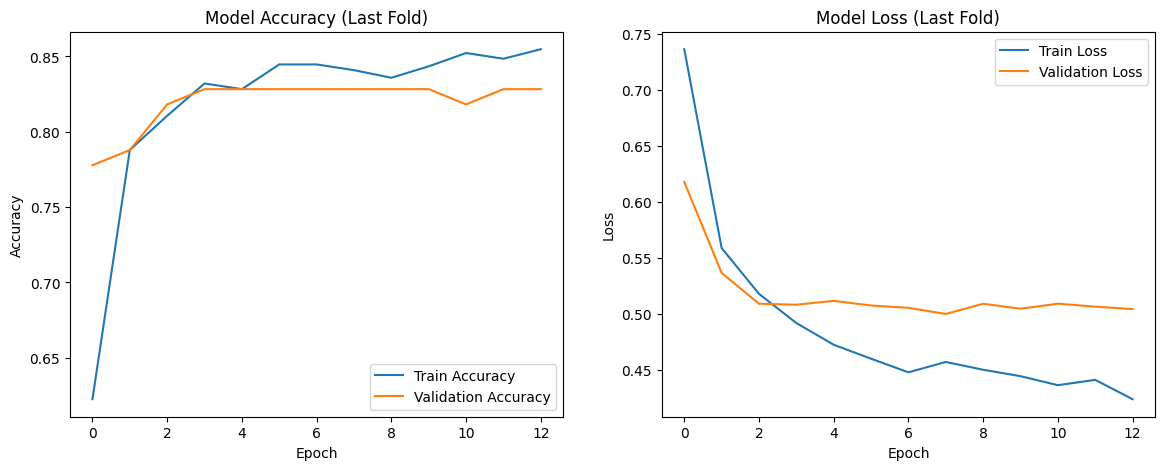

In [162]:
# Plot last fold's training history
last_hist = histories[-1]
hist_df = pd.DataFrame(last_hist)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Last Fold)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Model Loss (Last Fold)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


## **7. Prediction & Submission**
With our model trained, it's time to predict survival on the test set.

In [163]:
# Use the trained model to predict probabilities on the scaled test data
y_pred_probs = model.predict(X_test_scaled)

# Convert probabilities to binary predictions (0 or 1)
# If the probability is 0.5 or greater, predict 1 (Survived), otherwise predict 0
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() # Flatten to a 1D array

print("Sample predictions:", y_pred[:10])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Sample predictions: [0 1 0 0 1 0 1 0 1 0]


### **7.1. Creating the Submission File**
Finally, we'll format our predictions into a CSV file as required by the Kaggle competition rules. The file needs two columns: `PassengerId` and `Survived`.

In [164]:
# Create a new DataFrame for the submission
submission = pd.DataFrame({
    'PassengerId': df_test_processed['PassengerId'], # Get PassengerId from the processed test set
    'Survived': y_pred
})

# Save the DataFrame to a CSV file, without the pandas index
submission.to_csv('./data/submission.csv', index=False)

print("Submission file created successfully!")
submission.head()

Submission file created successfully!


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
